## Intro

Analysis : integrate three modeling for a pendulum system 1 VJEPA 2 HNN 3 LNN.
All models learn from the same dynamics of the pendulum, then we compare them through their learned phase-space representation.

Important Notes:
- V-JEPA : predicts future visual features instead of raw pixels. Uses masking, learns embeddings that capture dynamics. It operates in latent space with no pixel-level reconstruction.

- HNN : Hamiltonian embeds energy conservation into learning. It learns a scalar Hamiltonian function $H(q,p)$ that the models predicted dynamics automatically conserve energy. They want data in coordinates (angle $q$ and momentum $p$) and output time derivatives $\dot q, \dot p$ via the Hamiltonian's gradients.

- LNN : LNNs embed Lagrangian mechanics, learning a function that yields the systems equations of motion via EL Equation. They work with coordinates and velocities directly. They produce models that conserve energy and respect physical symmetries, sometimes better than HNNs.


After we train all on a pendulum, we explore the phase-space represnetations. The phase space of a pendulum consists of closed orbits for different energies. We compare the learned representations by visualizing trajectories in this space (via latent embeddings for V-JEPA or predicted $(q,p)$ for HNN/LNN. We try to evaluate how well each model conserves energy or predicts dynamics.

### Simulation :
To simulate pendulum data, we use a simple pendulu with unit length and gravity. The state is $(q, \dot q)$ where $q$ is the angular displacement from the downward vertical (in radians), and $\dot q$ is angular velocity. . We generate multiple trajectories with random initial angles and velocities, and record the state sequences and corresponding video frames. s: We choose initial $q \in [-\frac{\pi}{2}, \frac{\pi}{2}]$ (to avoid starting fully inverted) and initial $\omega \in [-2, 2]$ (moderate energy). Each trajectory lasts for a short duration (e.g. 1.5 seconds) sampled at a fixed FPS to yield a sequence of frames. Here we use 16 frames per trajectory. We also define a helper to render a pendulum image for a given angle. We draw a pendulum rod and bob on a plain background. During training, we will apply random masking to these images (e.g. blanking out random patches) to simulate occlusions and force the model to learn robust representations.

In [1]:
import numpy as np
from math import sin, cos
from PIL import Image, ImageDraw

# Pendulum and rendering settings
IMG_SIZE = 64            # image resolution (square)
PIVOT = (IMG_SIZE//2, int(0.3*IMG_SIZE))  # pivot x at center, y at 30% from top
ROD_LENGTH = int(0.3*IMG_SIZE)           # rod length in pixels (30% of image height)
BOB_RADIUS = 3                           # bob radius in pixels

def pendulum_dynamics(t, state):
    """Continuous pendulum ODE: state = [q, w]; returns [dq_dt, dw_dt]."""
    q, w = state
    dq_dt = w
    dw_dt = -sin(q)  # (g=1, l=1)
    return np.array([dq_dt, dw_dt])

def simulate_pendulum(q0, w0, T=1.5, steps=16):
    """Simulate pendulum from initial angle q0 and angular velocity w0."""
    t_seq = np.linspace(0, T, steps)
    dt = t_seq[1] - t_seq[0]
    states = np.zeros((steps, 2))
    states[0] = [q0, w0]
    # simple numerical integration (RK4 or Euler)
    for i in range(1, steps):
        # RK4 integration for better accuracy
        x = states[i-1]
        k1 = pendulum_dynamics(t_seq[i-1], x)
        k2 = pendulum_dynamics(t_seq[i-1] + dt/2, x + dt*k1/2)
        k3 = pendulum_dynamics(t_seq[i-1] + dt/2, x + dt*k2/2)
        k4 = pendulum_dynamics(t_seq[i], x + dt*k3)
        states[i] = x + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)
    return t_seq, states

def render_pendulum_image(angle):
    """Render a 64x64 image of pendulum at given angle (in radians)."""
    # Coordinates of bob given angle (0 = downward)
    x0, y0 = PIVOT
    # Pendulum bob position (angle measured clockwise from downward vertical)
    x_bob = x0 + ROD_LENGTH * sin(angle)
    y_bob = y0 + ROD_LENGTH * cos(angle)
    img = Image.new('RGB', (IMG_SIZE, IMG_SIZE), color=(255,255,255))  # white background
    draw = ImageDraw.Draw(img)
    # Draw rod
    draw.line([x0, y0, x_bob, y_bob], fill=(0,0,0), width=2)
    # Draw bob
    draw.ellipse([x_bob-BOB_RADIUS, y_bob-BOB_RADIUS, x_bob+BOB_RADIUS, y_bob+BOB_RADIUS],
                 fill=(0,0,255))  # blue bob
    return img

# Generate training dataset
np.random.seed(0)
num_trajectories = 100   # e.g. 100 training trajectories
trajectories = []        # will hold sequences of states
frames = []              # will hold sequences of images
for _ in range(num_trajectories):
    q0 = np.random.uniform(-1.5, 1.5)    # initial angle (radians)
    w0 = np.random.uniform(-1.5, 1.5)    # initial angular velocity
    t_seq, states = simulate_pendulum(q0, w0, T=1.5, steps=16)
    trajectories.append(states)
    # Render frames for this trajectory
    seq_imgs = [render_pendulum_image(q) for q, _ in states]
    frames.append(seq_imgs)

# Convert lists to arrays for convenience
trajectories = np.array(trajectories)    # shape (100, 16, 2)




We now have trajectories containing the true states (angle $q$ and angular velocity $w$) for each time-step, and frames containing the corresponding rendered images. These will be used to train the models.

V-JEPA: Vision Joint Embedding Predictive Architecture

Model Architecture: For V-JEPA, we build a simple encoder-predictor setup:
 An encoder network $f_{\theta}$ that takes an image (or a set of context frames) and outputs a latent representation $z$. In practice, we use a small convolutional neural network (CNN) to encode a single frame into a low-dimensional embedding. We will choose a 2-dimensional latent for interpretability (so the model is forced to learn a 2D representation of the pendulum’s state, analogous to angle and angular velocity).
  
  A predictor network $g_{\phi}$ that takes the latent encoding of the context and predicts the latent encoding of a target future frame. Here we use a simple multilayer perceptron (MLP) that maps $z_{\text{context}}$ to $z_{\text{pred}}$.

Training setup: We train the V-JEPA by sampling pairs of frames from each trajectory: one as context (e.g. an initial frame) and one as a target at a later time. The context image is passed through $f_{\theta}$ to get $z_c$; the target image is passed through $f_{\theta}$ (with shared weights) to get the true $z_t$; and $g_{\phi}(z_c)$ produces a predicted $z_{pred}$. The loss is the mean-squared error (MSE) between $z_{pred}$ and $z_t$. Importantly, we apply random masking to input frames: we zero-out a random 20% of image pixels (or a random patch) in both context and target images during training. This encourages the model to learn a robust latent representation that can predict missing information​. (In more advanced setups, one might mask specific regions of the video and predict their features​ , but here we use simple random masks as a proxy.)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the V-JEPA encoder (small CNN) and predictor MLP
class VJEPAEncoder(nn.Module):
    def __init__(self, latent_dim=2):
        super().__init__()
        # Simple CNN: 2 conv layers + 1 fully connected
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2, padding=2)  # input 3x64x64 -> 16x32x32
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=2) # 16x32x32 -> 32x16x16
        self.fc = nn.Linear(32*16*16, latent_dim)

    def forward(self, x):
        # x: batch of images, shape (N, 3, 64, 64)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)       # flatten
        z = self.fc(x)                  # latent representation
        return z

class VJEPAPredictor(nn.Module):
    def __init__(self, latent_dim=2):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, latent_dim)
        )
    def forward(self, z):
        return self.mlp(z)

# Initialize models
latent_dim = 2
encoder = VJEPAEncoder(latent_dim=latent_dim)
predictor = VJEPAPredictor(latent_dim=latent_dim)

# Optimizer
optim = torch.optim.Adam(list(encoder.parameters()) + list(predictor.parameters()), lr=1e-3)


Training V-JEPA: We iterate over the dataset of frame sequences. For each sequence, we randomly choose a context frame and a target frame (e.g., first and last frame, or a random pair with the target after the context in time). We apply a random mask to each frame (here implemented as random pixel dropout) and feed them through the encoder and predictor as described. The loss is calculated and used to update the networks.

In [3]:
# Prepare training data as PyTorch tensors
# (We convert images to tensors and scale to [0,1].)
frames_tensor = []
for seq in frames:
    # seq is a list of PIL images
    seq_t = [torch.tensor(np.array(img), dtype=torch.float32).permute(2,0,1)/255.0 for img in seq]
    frames_tensor.append(torch.stack(seq_t))  # shape (16, 3, 64,64) for each sequence
frames_tensor = torch.stack(frames_tensor)    # shape (num_trajectories, 16, 3, 64,64)

encoder.train()
predictor.train()
epochs = 10
for epoch in range(epochs):
    epoch_loss = 0.0
    # Loop over each trajectory
    for seq in frames_tensor:
        # Randomly select context and target indices (ensure target comes after context for causality)
        idx_context = 0
        idx_target = seq.size(0) - 1   # e.g., use first and last frame for training (could randomize)
        img_c = seq[idx_context:idx_context+1]  # shape (1,3,64,64)
        img_t = seq[idx_target:idx_target+1]
        # Apply random mask to images (20% of pixels)
        mask_c = torch.rand_like(img_c) < 0.8   # 1 where we keep pixel (80%), 0 where we mask
        mask_t = torch.rand_like(img_t) < 0.8
        masked_c = img_c * mask_c
        masked_t = img_t * mask_t
        # Forward pass
        z_c = encoder(masked_c)         # context latent
        z_t = encoder(masked_t)         # target latent (using encoder as target branch)
        z_pred = predictor(z_c)         # predicted target latent
        loss = F.mse_loss(z_pred, z_t)  # prediction loss in latent space
        # Backpropagation
        optim.zero_grad()
        loss.backward()
        optim.step()
        epoch_loss += loss.item()
    epoch_loss /= len(frames_tensor)
    if epoch % 2 == 0:
        print(f"Epoch {epoch}: VJEPA training loss = {epoch_loss:.4f}")


Epoch 0: VJEPA training loss = 0.0021
Epoch 2: VJEPA training loss = 0.0001
Epoch 4: VJEPA training loss = 0.0001
Epoch 6: VJEPA training loss = 0.0000
Epoch 8: VJEPA training loss = 0.0000


Model Architecture: The HNN model learns a neural network $H_{\theta}(q,p)$ that approximates the system’s Hamiltonian (energy). For a simple pendulum, the true Hamiltonian (with $m=l=1$) is $H = \frac{1}{2}p^2 + (1-\cos q)$, but the network will learn it from data. We use a small MLP for $H_{\theta}$ that takes $(q,p)$ as input (2-dim) and outputs a scalar. The HNN then predicts dynamics by analytical differentiation of $H$ (autograd for easy calculations).

Training data: We supervise the HNN using the true derivatives from our simulation. For each state $(q,p)$ in the training trajectories (excluding the last frame), we know the true $\dot q$ and $\dot p$ (either directly from the ODE or by finite difference between successive states). Here we will use the ODE: true $\dot q = \omega = p$, and true $\dot p = -\sin(q)$. We train the HNN to minimize MSE between predicted and true derivatives.

By learning $H$ and using the above gradient relations, the HNN’s vector field is guaranteed to be conservative (zero energy dissipation). This inductive bias helps it respect conservation laws exactly​). Indeed, an HNN tends to produce trajectories that conserve the learned Hamiltonian over long times, unlike a generic neural net.

In [4]:
# Define HNN model: an MLP that outputs scalar H, plus a method to get derivatives
class HNN(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden_dim), nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim), nn.Tanh(),
            nn.Linear(hidden_dim, 1)  # output H scalar
        )
    def forward(self, x):
        # x: tensor of shape (N,2) with [q, p]
        H = self.net(x)  # shape (N,1)
        return H

    def time_derivative(self, x):
        # Compute Hamiltonian derivatives to get [dq_dt, dp_dt]
        # Ensure gradients can be computed
        x = x.requires_grad_(True)
        H = self.net(x).sum()  # sum to get scalar (for autograd grad)
        # Compute gradient dH/dx = [dH/dq, dH/dp]
        grad = torch.autograd.grad(H, x, create_graph=True)[0]  # shape (N,2)
        dq_dt = grad[:, 1]          # dH/dp
        dp_dt = -grad[:, 0]         # -dH/dq
        return torch.stack([dq_dt, dp_dt], dim=1)  # shape (N,2)

# Initialize HNN and optimizer
hnn = HNN(hidden_dim=64)
optimizer_hnn = torch.optim.Adam(hnn.parameters(), lr=1e-3)

# Prepare training data for HNN (states and time derivatives)
states = trajectories.reshape(-1, 2)            # all (q,p) pairs from all trajectories
# True derivatives from ODE: [dq, dp] = [p, -sin(q)]
q_vals = states[:, 0]
p_vals = states[:, 1]
true_dq = p_vals
true_dp = -np.sin(q_vals)
true_derivs = np.stack([true_dq, true_dp], axis=1)
states_tensor = torch.tensor(states, dtype=torch.float32)
derivs_tensor = torch.tensor(true_derivs, dtype=torch.float32)

# Train HNN
hnn.train()
for epoch in range(101):
    # Forward pass: predict derivatives via HNN
    pred_deriv = hnn.time_derivative(states_tensor)
    loss_hnn = F.mse_loss(pred_deriv, derivs_tensor)
    optimizer_hnn.zero_grad()
    loss_hnn.backward()
    optimizer_hnn.step()
    if epoch % 20 == 0:
        print(f"Epoch {epoch}: HNN training loss = {loss_hnn.item():.4f}")


Epoch 0: HNN training loss = 0.5467
Epoch 20: HNN training loss = 0.2197
Epoch 40: HNN training loss = 0.0379
Epoch 60: HNN training loss = 0.0184
Epoch 80: HNN training loss = 0.0107
Epoch 100: HNN training loss = 0.0068


The LNN model learns a neural network $L_{\psi}(q, \dot q)$ that approximates the system’s Lagrangian. For the pendulum, the true Lagrangian is $L = T - V = \frac{1}{2}\dot q^2 - (1-\cos q)$, but again the network will learn it. We use an MLP that takes $(q, v)$ (where $v=\dot q$) and outputs a scalar $L$.

To predict accelerations use EL Equation.

Training data: We supervise the LNN using the true accelerations $ \ddot q$. For each state $(q, \dot q)$ (except the last in a trajectory), we know $\ddot q$ from the ODE ($\ddot q = -\sin q$). The loss is MSE between predicted and true $\ddot q$.

In [5]:
class LNN(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden_dim), nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim), nn.Tanh(),
            nn.Linear(hidden_dim, 1)  # output L scalar
        )
    def forward(self, x):
        # x: (N,2) with [q, v]
        L_val = self.net(x)
        return L_val

    def acceleration(self, x):
        # x: tensor of shape (N,2) = [q, v], requires grad for autograd
        q = x[:,0:1]  # (N,1)
        v = x[:,1:2]  # (N,1)
        q = q.requires_grad_(True)
        v = v.requires_grad_(True)
        # Compute L
        L = self.net(torch.cat([q, v], dim=1))
        # First-order partials
        dL_dq = torch.autograd.grad(L.sum(), q, create_graph=True)[0]       # ∂L/∂q, shape (N,1)
        dL_dv = torch.autograd.grad(L.sum(), v, create_graph=True)[0]       # ∂L/∂v, shape (N,1)
        # Second-order partials
        # ∂²L/(∂v²) and ∂²L/(∂q∂v) via gradients of dL_dv
        d2L = torch.autograd.grad(dL_dv.sum(), (q, v), create_graph=True)
        d2L_qdv = d2L[0]   # ∂/∂q (dL/dv) = ∂²L/∂q∂v, shape (N,1)
        d2L_v2  = d2L[1]   # ∂/∂v (dL/dv) = ∂²L/∂v², shape (N,1)
        # Solve for acceleration: v_dot = (dL/dq - d2L_qdv * v) / d2L_v2
        # (Add a small epsilon to denominator for numerical stability if needed)
        accel = (dL_dq - d2L_qdv * v) / (d2L_v2 + 1e-8)
        return accel  # (N,1)

# Initialize LNN and optimizer
lnn = LNN(hidden_dim=64)
optimizer_lnn = torch.optim.Adam(lnn.parameters(), lr=1e-3)

# Prepare training data for LNN: [q, v] and true v_dot (acceleration)
states_qv = trajectories.reshape(-1, 2)  # [q, w] where w = v
q_vals = states_qv[:,0]; w_vals = states_qv[:,1]
true_vdot = -np.sin(q_vals)            # true acceleration
states_qv_tensor = torch.tensor(states_qv, dtype=torch.float32)
vdot_tensor = torch.tensor(true_vdot, dtype=torch.float32).unsqueeze(1)

# Train LNN
lnn.train()
for epoch in range(101):
    pred_vdot = lnn.acceleration(states_qv_tensor)       # predicted acceleration
    loss_lnn = F.mse_loss(pred_vdot, vdot_tensor)
    optimizer_lnn.zero_grad()
    loss_lnn.backward()
    optimizer_lnn.step()
    if epoch % 20 == 0:
        print(f"Epoch {epoch}: LNN training loss = {loss_lnn.item():.4f}")


Epoch 0: LNN training loss = 1903.9886
Epoch 20: LNN training loss = 99750.9375
Epoch 40: LNN training loss = 26664.6641
Epoch 60: LNN training loss = 26666.5898
Epoch 80: LNN training loss = 10105.1016
Epoch 100: LNN training loss = 2926.3372



With all models trained, we now analyze their learned representations in the phase space (the space of $q$ vs. $p$ or $q$ vs. $v$). We perform both qualitative visualization and quantitative evaluation:

- We expect that V-JEPA’s latent embeddings correspond to the physical state of the pendulum, since it needed to capture the pendulum’s configuration to predict future frames. To verify this, we take a new pendulum trajectory and feed each frame through the V-JEPA encoder to get latent $z_t = (z_{t1}, z_{t2})$. We then plot these latent points against the true angle and angular velocity.
- We can visualize the vector fields learned by HNN and LNN in the phase space and compare them to the true pendulum vector field. For a grid of points in $(q,p)$ space, we compute $\dot q, \dot p$.  Plotting the vector field arrows gives a global picture of each model’s learned dynamics. We expect HNN and LNN to closely match the true field since they were trained explicitly on derivatives.

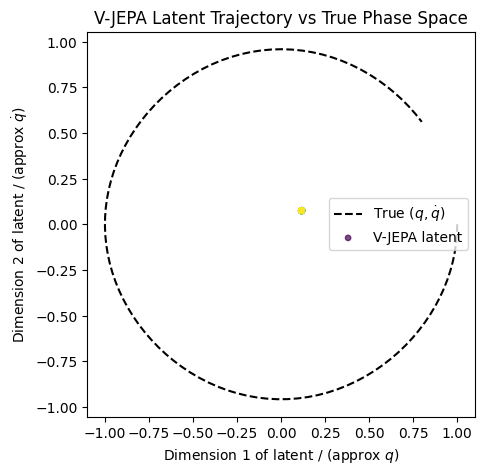

In [6]:
import matplotlib.pyplot as plt

# Disable grad for evaluation
encoder.eval(); hnn.eval(); lnn.eval()

# Simulate a new trajectory for evaluation
q0_test, w0_test = 1.0, 0.0  # e.g., 1 rad amplitude, zero initial velocity
t_seq, test_states = simulate_pendulum(q0_test, w0_test, T=6.0, steps=100)  # a longer trajectory
test_imgs = [render_pendulum_image(q) for q, _ in test_states]

# Get V-JEPA latents for each frame
test_imgs_tensor = torch.stack([torch.tensor(np.array(img), dtype=torch.float32).permute(2,0,1)/255.0
                                for img in test_imgs])  # (100,3,64,64)
with torch.no_grad():
    latents = encoder(test_imgs_tensor)  # shape (100, latent_dim)
latents = latents.numpy()

# Plot latent trajectory vs true phase trajectory
true_q = test_states[:,0]
true_w = test_states[:,1]
plt.figure(figsize=(5,5))
plt.plot(true_q, true_w, 'k--', label="True $(q, \dot q)$")            # true phase space path
plt.scatter(latents[:,0], latents[:,1], c=np.linspace(0,1,len(latents)), cmap='viridis',
            s=15, label="V-JEPA latent", alpha=0.7)
plt.xlabel("Dimension 1 of latent / (approx $q$)")
plt.ylabel("Dimension 2 of latent / (approx $\\dot q$)")
plt.title("V-JEPA Latent Trajectory vs True Phase Space")
plt.legend()
plt.show()
